# **Malware Classification using Convolutional Neural Networks**

**Importing necessary libraries :**

**General Purpose Libraries:** os, sys, and math for file handling and computations.

**Data Manipulation:** NumPy, Pandas, SciPy for numerical analysis and data handling.

**Visualization Tools:** Matplotlib, Seaborn for plotting data and results.

**Machine Learning Tools:** scikit-learn for metrics and train-test splitting.

**Deep Learning Framework:** TensorFlow and Keras for building and training CNN models.



In [1]:
import os
import sys
from math import log
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import scipy as sp
import pandas as pd
import pickle
import seaborn as sns
from sklearn import metrics
from PIL import Image, Image as PILImage
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator,
    array_to_img,
    load_img,
    img_to_array,
)
from tensorflow.keras.layers import (
    Input,
    Dense,
    Dropout,
    Flatten,
    Conv2D,
    MaxPooling2D,
    BatchNormalization,
)
from tensorflow.keras.metrics import AUC
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

**Configure project paths**

This cell sets up the main directory paths required for the project.
It defines the base path, raw data path, combined dataset path, and save path.

In [2]:
base_path = "C:/Users/Barouni/Downloads/Malware_Classification-20250116T182655Z-001/Malware_Classification"
data_path = os.path.join(base_path, "dataRaw")
path_root = os.path.join(base_path, "dataset")
save_path = os.path.join(base_path, "processed_images")

The following cell allows us to process hexadecimal **.bytes** files stored
in the 'dataRaw' folder.

Each file is read, converted into a 2D numerical array,and saved as a PNG image in the 'processed_images' folder.

In [3]:
# Create the save directory if it doesn't exist
if not os.path.exists(save_path):
    os.makedirs(save_path)

## Function to process hexadecimal files into PNG images
def convertAndSave(array, name):
    print(f'Processing {name}')
    if array.shape[1] != 16:  # Verify if the data is hexadecimal
        raise ValueError("Invalid input format. Expected 16 columns.")

    # Calculate the dimensions of the image
    b = int((array.shape[0] * 16) ** 0.5)
    b = 2 ** (int(log(b) / log(2)) + 1)
    a = int(array.shape[0] * 16 / b)
    array = array[:a * b // 16, :]
    array = np.reshape(array, (a, b))

    # Convert to image and save
    im = Image.fromarray(np.uint8(array))
    im.save(os.path.join(save_path, name + '.png'), "PNG")
    print(f"Image saved: {os.path.join(save_path, name + '.png')}")
    return im

# Get the list of .bytes files
files = os.listdir(data_path)
print('Files in directory:', files)

# Process each file one by one
for counter, name in enumerate(files):
    if not name.endswith('.bytes'):  # Process only .bytes files
        continue

    # Read the file and convert the data
    with open(os.path.join(data_path, name), 'r') as f:
        array = []
        for line in f:
            xx = line.split()
            if len(xx) != 17:
                continue
            array.append([int(i, 16) if i != '??' else 0 for i in xx[1:]])

    # Save the image
    convertAndSave(np.array(array), name.split('.')[0])

    # Clean up variables
    del array

print("All images have been processed and saved successfully!")

Files in directory: ['malware']
All images have been processed and saved successfully!


# **PreProcessing**

# ImageDataGenerator Setup for Data Augmentation and Dataset Splitting

This code sets up an `ImageDataGenerator` for augmenting image data and splitting it into training and testing sets. The generator will apply real-time data augmentation during training to enhance the model's generalization ability. It also divides the dataset, using 30% for testing and 70% for training.

### Breakdown:
1. **`ImageDataGenerator`**: This is a utility for applying real-time data augmentation, which helps to prevent overfitting by applying random transformations (e.g., rotations, flips) to the images.
   - **`testing_split=0.3`**: Specifies that 30% of the dataset will be used for testing, while the remaining 70% will be used for training.

2. **Training Data (`train_batches`)**:
   - **`flow_from_directory`**: This function loads images from the specified directory and applies the augmentations defined by the `ImageDataGenerator`.
   - **`target_size=(64, 64)`**: Resizes the images to a uniform size of 64x64 pixels.
   - **`batch_size=128`**: Sets the number of images to process in each batch.
   - **`subset='training'`**: Selects the training subset (70% of the dataset).
   - **`class_mode='categorical'`**: Indicates that the labels are categorical (for multi-class classification).

3. **Validation Data (`test_batches`)**:
   - Similar to `train_batches`, but this fetches the testing data (30% of the dataset) to evaluate the model’s performance during training.
   - **`subset='testing'`**: Specifies the testing subset for model evaluation.

This setup allows for effective model training with augmented data and ensures the model is evaluated on a separate testing set.





In [4]:
datagen = ImageDataGenerator(
    validation_split=0.3 
)


train_batches = datagen.flow_from_directory(
    directory=path_root,
    target_size=(64, 64),
    batch_size=256,
    subset='training',
    class_mode='categorical',      
)


test_batches = datagen.flow_from_directory(
    directory=path_root,
    target_size=(64, 64),
    batch_size=256,
    subset='validation',
    class_mode='categorical',
)


Found 4620 images belonging to 25 classes.
Found 1964 images belonging to 25 classes.


This command outputs a dictionary where keys represent the class names (e.g., malware families) and values represent their corresponding numerical labels.

In this case, the dataset consists of 25 malware classes.

In [5]:
test_batches.class_indices

{'Adialer.C': 0,
 'Agent.FYI': 1,
 'Allaple.A': 2,
 'Allaple.L': 3,
 'Alueron.gen!J': 4,
 'Autorun.K': 5,
 'C2LOP.P': 6,
 'C2LOP.gen!g': 7,
 'Dialplatform.B': 8,
 'Dontovo.A': 9,
 'Fakerean': 10,
 'Instantaccess': 11,
 'Lolyda.AA1': 12,
 'Lolyda.AA2': 13,
 'Lolyda.AA3': 14,
 'Lolyda.AT': 15,
 'Malex.gen!J': 16,
 'Obfuscator.AD': 17,
 'Rbot!gen': 18,
 'Skintrim.N': 19,
 'Swizzor.gen!E': 20,
 'Swizzor.gen!I': 21,
 'VB.AT': 22,
 'Wintrim.BX': 23,
 'Yuner.A': 24}

**batches** generated with ImageDataGenerator() is an iterator. Hence, we use next() to go through all its elements and generate a batch of images and labels from the data set.

In [6]:
imgs, labels = next(train_batches)

In [7]:
test_imgs,test_labels= next(test_batches)

Our images are in RGB with shape 64x64 [width x length x depth].

In [8]:
imgs.shape

(256, 64, 64, 3)

**labels** has the shape (batch_size, number of classes).

In [9]:
test_labels.shape

(256, 25)

The following function allows us to visualize test batches of images along with their labels.

* It takes a list or array of images (ims) and displays them in a grid layout within a Jupyter Notebook.

* The function supports optional labels (titles) to display the predicted class name of each image.

* Images are displayed in a grid of rows x cols, and the size of the grid can be adjusted with the figsize parameter.

* The function is specifically tailored to handle batches of images with up to 50 examples per call.



In [10]:

def plots(ims, figsize=(20,30), rows=10, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    
    num_images = len(ims)
    cols = len(ims) // rows if len(ims) % rows == 0 else (len(ims) // rows) + 1
    f = plt.figure(figsize=figsize)
    
    for i in range(num_images):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        
        if titles is not None:
            # Ensure titles list is not empty and has enough entries
            if len(titles) > i:
                # Using class_indices to map labels to titles if titles are numeric indices
                title_index = np.argmax(titles[i]) if np.ndim(titles[i]) > 0 else titles[i]
                if title_index < len(list(train_batches.class_indices.keys())):
                    title = list(train_batches.class_indices.keys())[title_index]
                    sp.set_title(title, fontsize=16)
                
        plt.imshow(ims[i], interpolation=None if interp else 'none')

    plt.show()


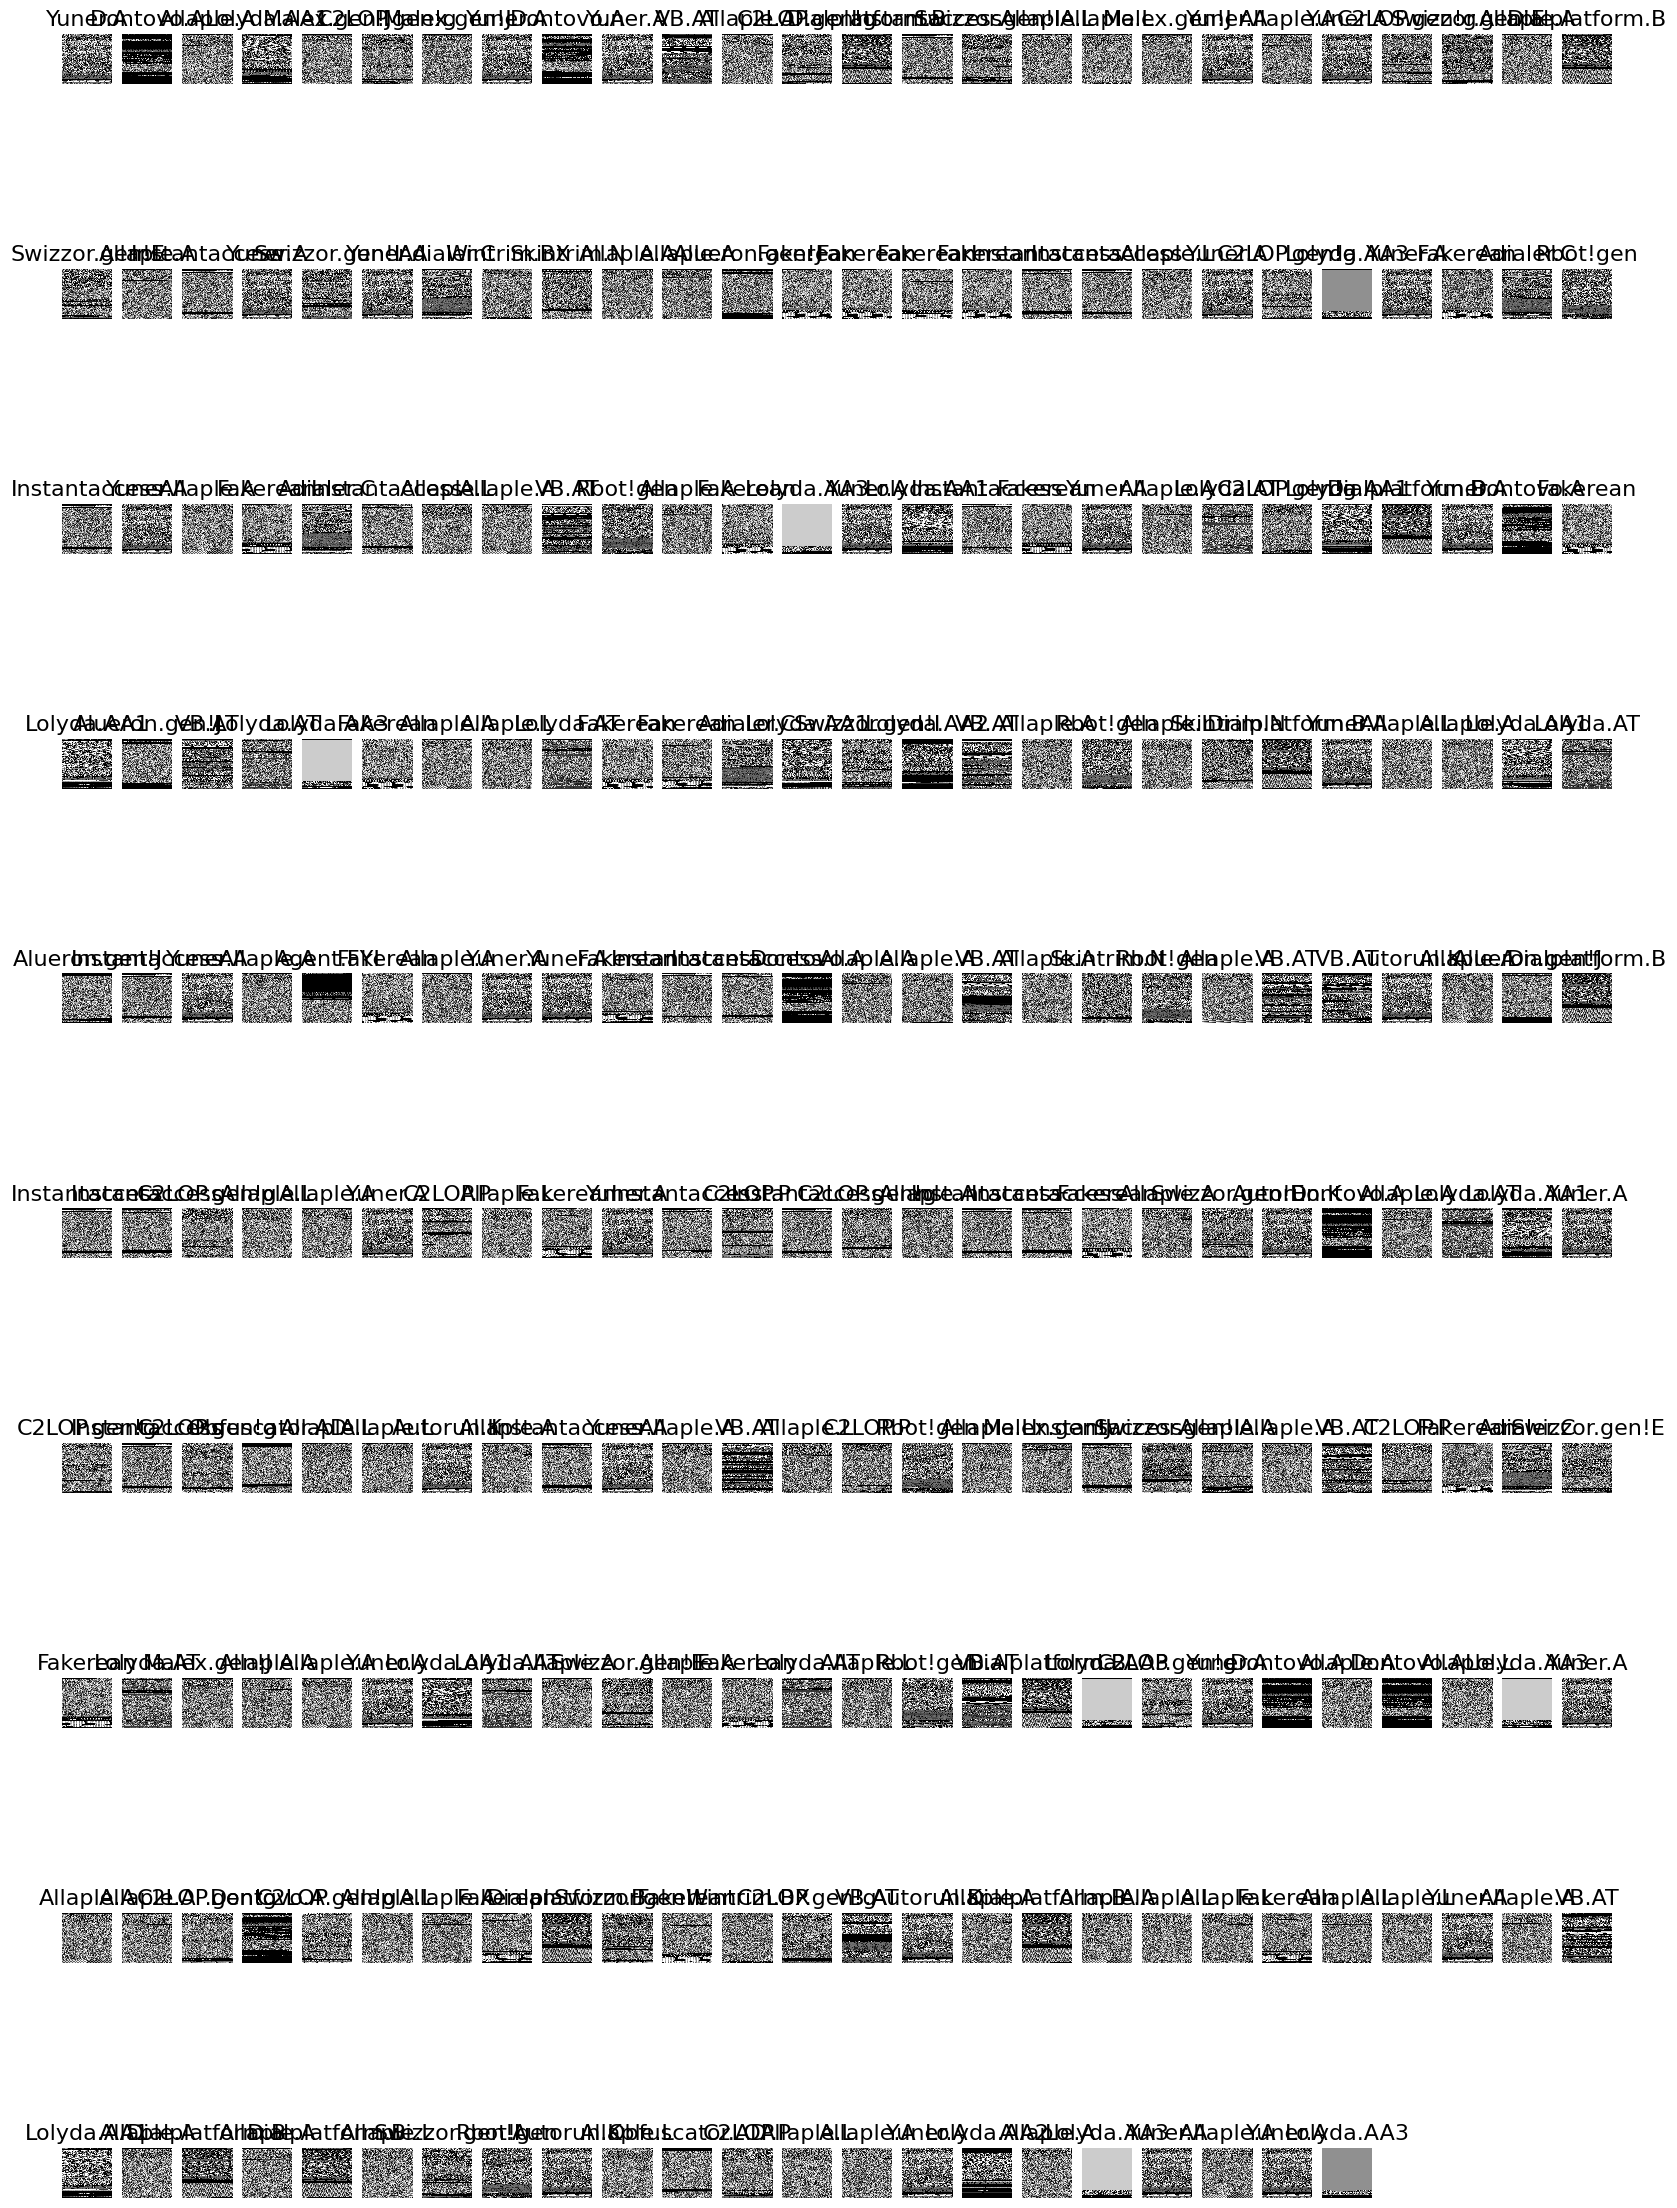

In [11]:
plots(imgs, titles = labels)

We can clearly observe noticeable differences between the classes in terms of their visual patterns.

# **Analysis**
All our images are now preprocessed and ready to be used for training and evaluation. Let’s examine the distribution of data across the classes to ensure balance and identify any potential class imbalances:

<BarContainer object of 25 artists>

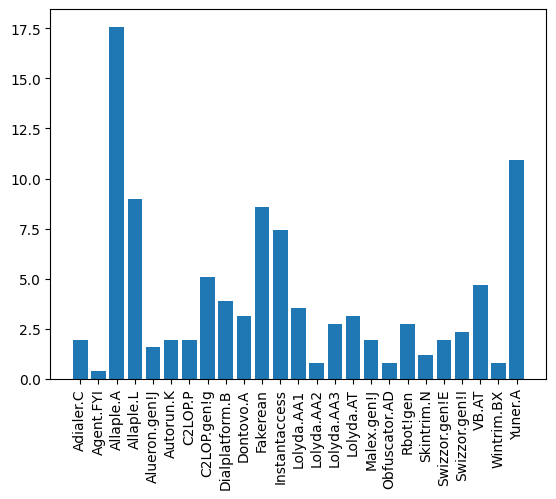

In [12]:
classes = train_batches.class_indices.keys()
perc = (sum(labels)/labels.shape[0])*100
plt.xticks(rotation='vertical')
plt.bar(classes,perc)

We can see that our dataset is quite unbalanced : a lot of Malwares belong to class 2 : **Allaple.A** and class 3 : **Allaple.L** !


# **Train and test**

# **Dataset Splitting and Normalization**

Previously, we split the dataset into training and testing sets using `train_test_split`.  
 The images were normalized by dividing their pixel values by 255, scaling them to the range [0, 1].  
 The split was as follows:  
 * **Training set (70% of the data):** Used to train the model.  
 * **Testing set (30% of the data):** Used to evaluate the model's performance.  
 After splitting, the shapes of `X_train`, `X_test`, `y_train`, and `y_test` were displayed to verify the split.

# **Transition to k-fold Cross-Validation**

 We are now using **k-fold cross-validation** to ensure robust model evaluation.  
 This method divides the dataset into `k` subsets (folds). The model is trained on `k-1` folds and tested on the remaining fold, repeating the process `k` times.  
 This approach reduces bias and provides a more reliable estimate of the model's performance.



In [13]:
# Parameters
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Data and labels (assumes imgs and labels are loaded)
X = imgs / 255.0  # Normalize images
y = labels

# Placeholder to store metrics for each fold
fold_metrics = []

# Initialize fold counter
fold_no = 1


# **Convolutional Neural Network Model**

**Our** **CNN** model designed with **Keras** has the following architecture:

- **Input Layer**: Accepts images with a shape of **256 x 256 x 3** (RGB images).  
- **Convolutional Layer 1**: **32 filters**, **(3 x 3)** kernel size, **ReLU activation function**, **'same' padding**.  
- **Batch Normalization**: Normalizes activations to stabilize training.  
- **Max Pooling Layer 1**: **(2 x 2)** pool size, reduces spatial dimensions.  
- **DropOut Layer 1**: **Dropping 20% of neurons** to prevent overfitting.  
- **Convolutional Layer 2**: **64 filters**, **(3 x 3)** kernel size, **ReLU activation function**, **'same' padding**.  
- **Batch Normalization**: Further stabilizes activations.  
- **Max Pooling Layer 2**: **(2 x 2)** pool size, further reduces spatial dimensions.  
- **DropOut Layer 2**: **Dropping 30% of neurons** to prevent overfitting.  
- **Convolutional Layer 3**: **128 filters**, **(3 x 3)** kernel size, **ReLU activation function**, **'same' padding**.  
- **Batch Normalization**: Ensures stable training.  
- **Max Pooling Layer 3**: **(2 x 2)** pool size, reduces spatial dimensions further.  
- **DropOut Layer 3**: **Dropping 40% of neurons** to prevent overfitting.  
- **Flatten Layer**: Converts **2D feature maps** into a **1D vector** for dense layers.  
- **Dense/Fully Connected Layer 1**: **64 neurons**, **ReLU activation function**.  
- **DropOut Layer 4**: **Dropping 50% of neurons** to further prevent overfitting.  
- **Output Layer**: **26 neurons**, **Softmax activation function** for multi-class classification.  

**Input shape**: **256 x 64 x 3**  


In [14]:
num_classes = 26

**The following functions calculate evaluation metrics for the model's performance:**

- **Recall**: Measures the proportion of true positives among all actual positive cases.  
  It is calculated as:  
  `Recall = True Positives / (True Positives + False Negatives)`

- **Precision**: Measures the proportion of true positives among all predicted positive cases.  
  It is calculated as:  
  `Precision = True Positives / (True Positives + False Positives)`

- **F1-Score**: Provides a harmonic mean of precision and recall, balancing the trade-off between them.  
  It is calculated as:  
  `F1-Score = 2 * (Precision * Recall) / (Precision + Recall)`

These functions are used to evaluate the quality of the model's predictions.


In [15]:
def recall_m(y_test, y_pred):
    true_positives = K.sum(K.round(K.clip(y_test * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_test, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def precision_m(y_test, y_pred):
    true_positives = K.sum(K.round(K.clip(y_test * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_test, y_pred):
    precision = precision_m(y_test, y_pred)
    recall = recall_m(y_test, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Building the model

In [16]:
# Define the Enhanced Malware Detection Model
def enhanced_malware_model(num_classes=25):
    model = Sequential([
        # First Convolutional Block
        # 32 filters, 3x3 kernel, ReLU activation, input shape 64x256x3 (RGB images)
        Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(64, 64, 3)),
        BatchNormalization(),  # Normalizes activations to improve training stability
        MaxPooling2D(pool_size=(2, 2)),  # Reduces spatial dimensions by half
        Dropout(0.2),  # Drops 20% of neurons to prevent overfitting

        # Second Convolutional Block
        # 64 filters, 3x3 kernel, ReLU activation
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),  # Normalizes activations to improve training stability
        MaxPooling2D(pool_size=(2, 2)),  # Reduces spatial dimensions by half
        Dropout(0.3),  # Drops 30% of neurons to prevent overfitting

        # Third Convolutional Block
        # 128 filters, 3x3 kernel, ReLU activation
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),  # Normalizes activations to improve training stability
        MaxPooling2D(pool_size=(2, 2)),  # Reduces spatial dimensions by half
        Dropout(0.4),  # Drops 40% of neurons to prevent overfitting

        # Flattening the convolutions
        Flatten(),  # Converts 2D feature maps into a 1D vector for dense layers

        # Dense Layers
        Dense(64, activation='relu'),  # Fully connected layer with 64 neurons
        Dropout(0.5),  # Drops 50% of neurons to prevent overfitting
        Dense(num_classes, activation='softmax')  # Output layer for multi-class classification
    ])

    # Compile the model
    model.compile(optimizer='adam',  # Adam optimizer for adaptive learning rates
                  loss='categorical_crossentropy',  # Loss function for multi-class classification
                  metrics=['accuracy', 'Recall', 'Precision', f1_m, AUC(name='auc')]  # Evaluation metrics
    )
    return model

In [17]:
# Create the model
malware_model = enhanced_malware_model()
malware_model.summary()

c:\Users\Barouni\Downloads\Malware_Classification-20250116T182655Z-001\Malware_Classification\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       524,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 25)             │         1,625 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 620,121 (2.37 MB)

 Trainable params: 619,673 (2.36 MB)

 Non-trainable params: 448 (1.75 KB)

This code performs k-fold cross-validation to evaluate the performance of a machine learning model.
The dataset is first split into training and testing sets. The training set is further divided into
k folds (5 in this case) to train and validate the model on different subsets of the data.
For each fold, the model is trained and validated, and the accuracy is recorded.
The best-performing model (based on validation accuracy) is then evaluated on the test set,
and its accuracy and classification report are generated.


In [18]:
# Split the dataset into training and testing sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Parameters for k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # Create 5 folds with shuffling
fold_no = 1  # Counter for folds
best_accuracy = 0  # Track the highest accuracy across folds
best_model = None  # Placeholder for the best-performing model

fold_metrics = []  # List to store metrics for each fold

# Perform k-fold cross-validation using the training data
for train_index, val_index in kf.split(X_train_full):
    print(f"Training on fold {fold_no}...")

    # Split the data into training and validation sets for this fold
    X_train, X_val = X_train_full[train_index], X_train_full[val_index]
    y_train, y_val = y_train_full[train_index], y_train_full[val_index]

    # Initialize and compile the enhanced malware detection model
    malware_model = enhanced_malware_model()

    # Train the model on the current training set
    malware_model.fit(X_train, y_train, epochs=10, batch_size=256, verbose=1)

    # Evaluate the model on the validation set
    val_preds = malware_model.predict(X_val)
    val_preds_classes = np.argmax(val_preds, axis=1)  # Get predicted class for each sample
    y_val_classes = np.argmax(y_val, axis=1)  # Convert one-hot encoded labels to class indices if necessary

    # Calculate accuracy for the current fold
    accuracy = accuracy_score(y_val_classes, val_preds_classes)
    print(f"Fold {fold_no} Accuracy: {accuracy}")

    # Store metrics for this fold
    fold_metrics.append({"fold": fold_no, "accuracy": accuracy})

    # Save the model if it has the highest accuracy so far
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = malware_model

    fold_no += 1  # Increment fold counter


print(f"\nBest Fold Accuracy: {best_accuracy}")

# Evaluate the best model on the test set
if best_model is not None:
    print("Evaluating the best model on the test set...")
    test_preds = best_model.predict(X_test)
    test_preds_classes = np.argmax(test_preds, axis=1)  # Get predicted class for each sample
    y_test_classes = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class indices if necessary

    test_accuracy = accuracy_score(y_test_classes, test_preds_classes)  # Calculate test set accuracy
    test_report = classification_report(y_test_classes, test_preds_classes)  # Generate classification report

    print(f"Test Set Accuracy: {test_accuracy}")
    print(f"Classification Report on Test Set:\n{test_report}")


Training on fold 1...
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - Precision: 0.0423 - Recall: 0.0184 - accuracy: 0.0552 - auc: 0.5083 - f1_m: 0.0256 - loss: 6.3245
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step - Precision: 0.1207 - Recall: 0.0429 - accuracy: 0.1227 - auc: 0.6351 - f1_m: 0.0633 - loss: 4.6034
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step - Precision: 0.3333 - Recall: 0.0123 - accuracy: 0.0920 - auc: 0.6280 - f1_m: 0.0237 - loss: 3.2325
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step - Precision: 0.7500 - Recall: 0.0184 - accuracy: 0.1043 - auc: 0.6904 - f1_m: 0.0359 - loss: 2.9430
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step - Precision: 0.2000 - Recall: 0.0061 - accuracy: 0.0982 - auc: 0.7202 - f1_m: 0.0119 - loss: 2.9350
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step - Precision: 0.8000 - Recall: 0.0245 - accuracy: 0.0859 - auc: 0.7305 - f1_m: 0.0476 - loss: 2.9038
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step - Precision: 1.0000 - Recall: 0

c:\Users\Barouni\Downloads\Malware_Classification-20250116T182655Z-001\Malware_Classification\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - Precision: 0.0128 - Recall: 0.0061 - accuracy: 0.0184 - auc: 0.4952 - f1_m: 0.0083 - loss: 6.7425
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step - Precision: 0.0980 - Recall: 0.0307 - accuracy: 0.0798 - auc: 0.6375 - f1_m: 0.0467 - loss: 4.5208
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step - Precision: 1.0000 - Recall: 0.0061 - accuracy: 0.1043 - auc: 0.6737 - f1_m: 0.0122 - loss: 3.0781
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 859ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.1043 - auc: 0.6558 - f1_m: 0.0000e+00 - loss: 3.0413
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.0920 - auc: 0.6579 - f1_m: 0.0000e+00 - loss: 3.0203
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.1288 - auc: 0.7136 - f1_m: 0.0000e+00 - loss: 2.9158
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - Precision: 0.7500 - Reca

c:\Users\Barouni\Downloads\Malware_Classification-20250116T182655Z-001\Malware_Classification\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - Precision: 0.0400 - Recall: 0.0184 - accuracy: 0.0245 - auc: 0.4841 - f1_m: 0.0252 - loss: 6.6738
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - Precision: 0.2222 - Recall: 0.0613 - accuracy: 0.1350 - auc: 0.6363 - f1_m: 0.0962 - loss: 4.2148
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - Precision: 0.8750 - Recall: 0.0429 - accuracy: 0.1779 - auc: 0.6908 - f1_m: 0.0819 - loss: 3.0111   
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - Precision: 1.0000 - Recall: 0.0552 - accuracy: 0.2699 - auc: 0.7296 - f1_m: 0.1047 - loss: 2.7614
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 838ms/step - Precision: 0.8667 - Recall: 0.0798 - accuracy: 0.2270 - auc: 0.7585 - f1_m: 0.1461 - loss: 2.7357
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step - Precision: 0.8276 - Recall: 0.1472 - accuracy: 0.3190 - auc: 0.8061 - f1_m: 0.2500 - loss: 2.4960
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 844ms/step - Precision: 0.7297 - Recall: 0.1656 - accuracy: 0.3006 -

c:\Users\Barouni\Downloads\Malware_Classification-20250116T182655Z-001\Malware_Classification\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - Precision: 0.0375 - Recall: 0.0184 - accuracy: 0.0368 - auc: 0.5063 - f1_m: 0.0247 - loss: 6.5520
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step - Precision: 0.2632 - Recall: 0.0613 - accuracy: 0.1411 - auc: 0.6468 - f1_m: 0.0995 - loss: 3.8601
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step - Precision: 1.0000 - Recall: 0.0123 - accuracy: 0.1166 - auc: 0.6458 - f1_m: 0.0242 - loss: 3.1429
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step - Precision: 1.0000 - Recall: 0.0061 - accuracy: 0.1411 - auc: 0.6228 - f1_m: 0.0122 - loss: 3.1314
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.1350 - auc: 0.6480 - f1_m: 0.0000e+00 - loss: 3.0410
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step - Precision: 1.0000 - Recall: 0.0061 - accuracy: 0.1595 - auc: 0.6478 - f1_m: 0.0122 - loss: 3.0536
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step - Precision: 0.7500 - Recall: 0.0184 - ac

c:\Users\Barouni\Downloads\Malware_Classification-20250116T182655Z-001\Malware_Classification\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - Precision: 0.0215 - Recall: 0.0122 - accuracy: 0.0366 - auc: 0.5629 - f1_m: 0.0156 - loss: 6.6859
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step - Precision: 0.0857 - Recall: 0.0183 - accuracy: 0.1220 - auc: 0.5966 - f1_m: 0.0302 - loss: 4.4627
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step - Precision: 0.6667 - Recall: 0.0122 - accuracy: 0.1463 - auc: 0.6751 - f1_m: 0.0240 - loss: 3.0605
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step - Precision: 1.0000 - Recall: 0.0061 - accuracy: 0.0915 - auc: 0.6586 - f1_m: 0.0121 - loss: 3.0359
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step - Precision: 0.3333 - Recall: 0.0061 - accuracy: 0.0915 - auc: 0.6345 - f1_m: 0.0120 - loss: 3.0488
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - Precision: 0.5000 - Recall: 0.0061 - accuracy: 0.1159 - auc: 0.6507 - f1_m: 0.0120 - loss: 3.0045
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step - Precision: 0.5714 - Recall: 0.0244 - accuracy: 0.1037 - auc: 0

c:\Users\Barouni\Downloads\Malware_Classification-20250116T182655Z-001\Malware_Classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Barouni\Downloads\Malware_Classification-20250116T182655Z-001\Malware_Classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Barouni\Downloads\Malware_Classification-20250116T182655Z-001\Malware_Classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined an

Saving the best model

In [19]:
import os
if not os.path.exists('models'):
    os.makedirs('models')

if best_model is not None:
    best_model.save('models/enhanced_malware_model.h5')
    print("Best model saved in the 'models' folder!")


Best model saved in the 'models' folder!


# This code calculates and visualizes class weights for imbalanced data to address the imbalance problem during model training.
#Class weights are computed using `sklearn` to balance the dataset by assigning higher weights to underrepresented classes.
#The calculated weights are then displayed as percentages in a bar chart for better understanding of the class distribution.
Here's the detailed process:
1. Convert one-hot encoded labels (if applicable) into a 1D array of class indices.
2. Compute class weights using the `compute_class_weight` function, which ensures balanced importance for each class.
3. Represent the class weights as a percentage of the total weight.
4. Visualize the percentages using a bar chart with annotated percentages on each bar.
This helps identify how the weights are distributed among the classes, making it easier to validate the balancing strategy.


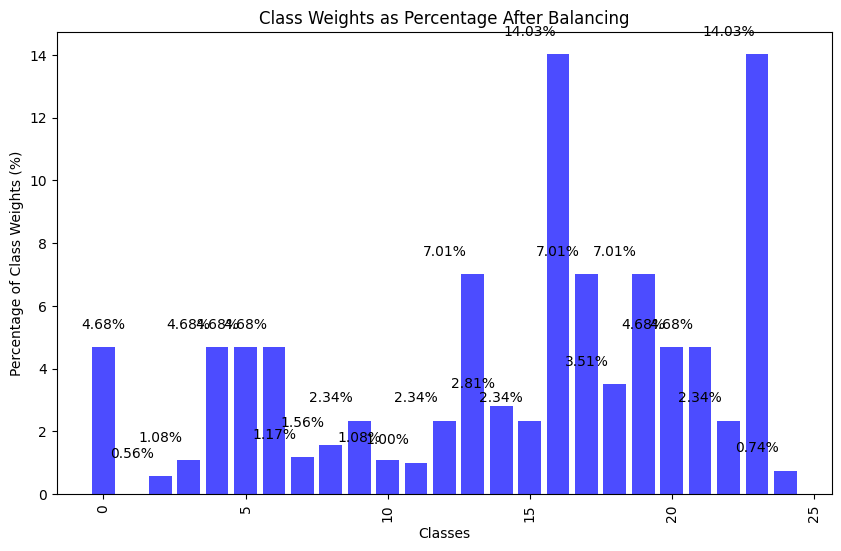

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import class_weight

# Assuming y_train is already in an appropriate format (1D or one-hot encoded).
# If y_train is one-hot encoded, use np.argmax to get class labels.
y_train_new = np.argmax(y_train, axis=1) if len(y_train.shape) > 1 else y_train

# Compute class weights to handle imbalanced data.
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',  # Ensures balanced class weights.
    classes=np.unique(y_train_new),  # Unique class labels in the data.
    y=y_train_new  # Class labels for weight computation.
)
class_weights_dict = {l: c for l, c in zip(np.unique(y_train_new), class_weights)}

# Extract classes and their corresponding weights.
classes = list(class_weights_dict.keys())
weights = list(class_weights_dict.values())

# Calculate the percentage for each class weight.
perc = (np.array(weights) / sum(weights)) * 100

# Plot a bar chart showing the class weights as percentages.
plt.figure(figsize=(10, 6))

# Create a bar for each class with its percentage.
bars = plt.bar(classes, perc, color='blue', alpha=0.7)

# Add percentage labels on top of each bar.
for i, v in enumerate(perc):
    plt.text(i, v + 0.5, f"{v:.2f}%", ha='center', va='bottom')

# Customize the plot.
plt.ylabel('Percentage of Class Weights (%)')  # Label for the y-axis.
plt.xlabel('Classes')  # Label for the x-axis.
plt.title('Class Weights as Percentage After Balancing')  # Title of the chart.

# Add class labels under each bar with rotation for better visibility.
plt.xticks(rotation=90)

# Display the chart.
plt.show()


In [21]:
print("X_train.shape:", X_train_full.shape)
print("X_test.shape:", X_test.shape)
print("y_train.shape:", y_train_full.shape)
print("y_test.shape:", y_test.shape)

X_train.shape: (204, 64, 64, 3)
X_test.shape: (52, 64, 64, 3)
y_train.shape: (204, 25)
y_test.shape: (52, 25)


In [22]:
from imblearn.under_sampling import RandomUnderSampler

# Assuming y_train is your original training labels
y_train_new = np.argmax(y_train, axis=1)

# Reshape X_train_full to 2D
X_train_full_2d = X_train_full.reshape(X_train_full.shape[0], -1)

# Apply Random Undersampling to the majority classes
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_full_2d, y_train_new)


In [23]:
y_train_new = y_train_resampled
X_train_full = X_train_resampled

### Model Training

The following code trains the `malware_model` using the `train_batches` for training and `test_batches` for validation. It runs for 10 epochs and applies class weights (`class_weights_dict`) to handle class imbalance during training. This ensures that the model learns appropriately from imbalanced classes.


In [24]:
malware_model.fit(
    train_batches,
    validation_data=test_batches,
    epochs=20,
    class_weight=class_weights_dict  
)

malware_model.save('models/final_malware_model.h5')
print("Final model saved!")

c:\Users\Barouni\Downloads\Malware_Classification-20250116T182655Z-001\Malware_Classification\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - Precision: 0.8478 - Recall: 0.0336 - accuracy: 0.1628 - auc: 0.7130 - f1_m: 0.0657 - loss: 3.8149 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.1431 - val_auc: 0.6850 - val_f1_m: 0.0000e+00 - val_loss: 3.1972
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - Precision: 0.7798 - Recall: 0.0272 - accuracy: 0.1346 - auc: 0.7346 - f1_m: 0.0518 - loss: 3.5603 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.1624 - val_auc: 0.6655 - val_f1_m: 0.0000e+00 - val_loss: 3.1096
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - Precision: 0.6682 - Recall: 0.0572 - accuracy: 0.1745 - auc: 0.7431 - f1_m: 0.0987 - loss: 3.3702 - val_Precision: 1.0000 - val_Recall: 0.0107 - val_accuracy: 0.1619 - val_auc: 0.6594 - val_f1_m: 0.0217 - val_loss: 3.0662
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - Precision: 0.6191 - Recall: 0.0596 - accuracy: 0.1449 - auc: 0.7662 - f1_m: 0.0974 - loss: 3.1807 - va

Final model saved!


### Loading the Final Model

The model is loaded from the specified path `models/final_malware_model.h5` using the `load_model` function. This function also loads custom evaluation metrics (`f1_m`, `precision_m`, and `recall_m`) that were defined during the model training process.


In [25]:
# Final Model Saved
model_path = 'models/final_malware_model.h5'
final_model = load_model(model_path, custom_objects={'f1_m': f1_m, 'precision_m': precision_m, 'recall_m': recall_m})


final_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_m, precision_m, recall_m])


results = final_model.evaluate(test_batches)


print(f"Loss: {results[0]}")  # Perte (loss)
print(f"Accuracy: {results[1]}")  # Accuracy
print(f"Recall: {results[2]}")  # Recall
print(f"Precision: {results[3]}")  # Precision
print(f"F1 Score: {results[4]}")  # F1 Score

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 828ms/step - accuracy: 0.8310 - f1_m: 0.8611 - loss: 1.3348 - precision_m: 0.9183 - recall_m: 0.8106
Loss: 1.3278008699417114
Accuracy: 0.8309572339057922
Recall: 0.8610094785690308
Precision: 0.919019341468811
F1 Score: 0.8100018501281738


# **Confusion Matrix**

Lets analyse our results.

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 800ms/step


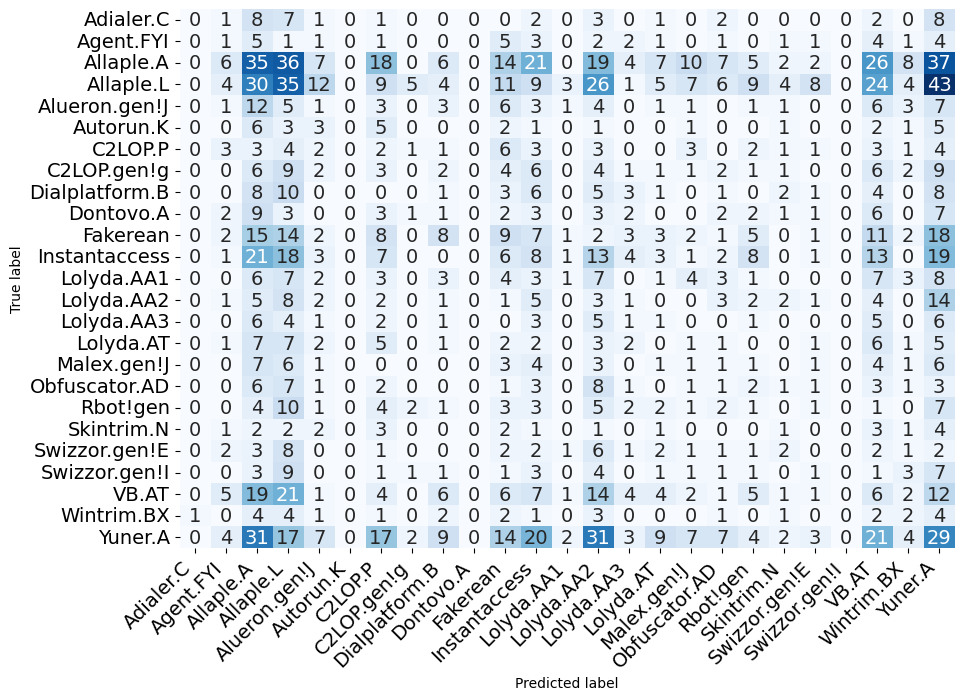

In [26]:
# Generate predictions for the test set
y_pred = final_model.predict(test_batches, batch_size=256)

# Retrieve the true labels from the test set
y_true = test_batches.labels  # True labels

# Convert the predictions into class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Function to display the confusion matrix as a heatmap
def plot_confusion_matrix(conf_matrix, class_names, figsize=(10, 7), fontsize=14):
    df_cm = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)
    plt.figure(figsize=figsize)
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": fontsize})
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks(rotation=45, ha='right', fontsize=fontsize)
    plt.yticks(rotation=0, ha='right', fontsize=fontsize)
    plt.show()

# Get the class names from the indices of the training set
class_names = list(test_batches.class_indices.keys())  # List of class names

# Display the confusion matrix
plot_confusion_matrix(conf_matrix, class_names)


**Confusion Matrix Analysis**

From our confusion matrix, we can observe that while most malware families are correctly classified, there are a few notable misclassifications.

These observations highlight the importance of addressing class imbalance and refining feature extraction for closely related families.


### Image Prediction with the Final Model

This section demonstrates how to load an image, preprocess it, and make a prediction using the trained model. The process involves several steps:

1. **Loading and Preprocessing the Image**:
   - The image is loaded from the specified path (`image_path`) and resized to match the input size expected by the model (256x256 pixels).
   - The image is then displayed using `matplotlib` to visually confirm that it has been loaded correctly.

2. **Preparing the Image for Prediction**:
   - The image is converted into a numpy array using `img_to_array`, which allows it to be fed into the model.
   - The pixel values of the image are normalized by dividing by 255, scaling them between 0 and 1, which is standard practice for image input in neural networks.
   - The image is reshaped to match the model's input dimensions, which typically expects a batch of images, even if it is just one image. Thus, the shape is adjusted to `(1, 64, 256, 3)`.

3. **Making the Prediction**:
   - The model's `predict` method is called to obtain the prediction for the input image.
   - The predicted class is determined by finding the index of the highest probability in the model's output. This is done using `np.argmax`, which returns the index of the class with the highest score.
   - The corresponding class name is retrieved from the `class_names` list using the predicted index.

4. **Displaying the Result**:
   - Finally, the predicted class and the probabilities for each class are printed out. This gives insight into the model's confidence for each class.

This approach allows you to input an image into the model, get the predicted class, and visualize the prediction along with the model's confidence.


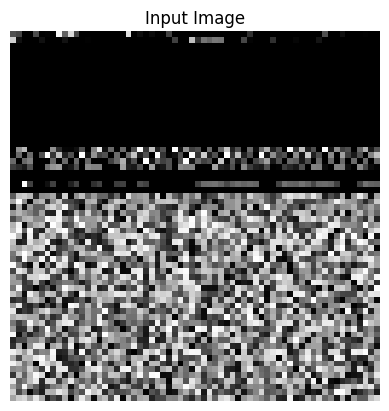

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted Class: Agent.FYI
Prediction Probabilities: [[2.9237623e-11 9.9938297e-01 1.7913690e-11 3.2285985e-10 1.3492395e-04
  6.1510318e-13 4.4383249e-08 9.1663042e-09 1.3252358e-11 3.7719589e-04
  4.5618936e-18 8.1711506e-11 8.5715867e-05 1.8733024e-05 1.4427898e-10
  6.9982498e-08 3.2105893e-07 2.2311646e-11 1.2742958e-16 2.3042439e-10
  1.5784777e-09 5.8096258e-12 7.7298040e-10 1.9260082e-08 2.2323744e-10]]


In [29]:
# Load and preprocess the image
image_path = "dataset/Agent.FYI/00bd1a12d592bdca96cdb6421c17922a.png"
input_image = load_img(image_path, target_size=(64, 64))  # Resize directly to model's input size
plt.imshow(input_image)
plt.title("Input Image")
plt.axis('off')
plt.show()

# Prepare the image for prediction
image_array = img_to_array(input_image)  # Convert the image to a numpy array
image_array = image_array / 255.0  # Normalize the image
image_array = image_array.reshape(1, 64, 64, 3)  # Reshape for model input

# Make the prediction
model_prediction = final_model.predict(image_array)
predicted_class_index = np.argmax(model_prediction)  # Get the index of the predicted class
predicted_class = class_names[predicted_class_index]  # Get the name of the predicted class

# Display the result
print("Predicted Class:", predicted_class)
print("Prediction Probabilities:", model_prediction)

## Evaluation of Model Performance with Confusion Matrix

This section of the code evaluates the performance of the trained model using a confusion matrix and visualizes key metrics: True Positives (TP), False Positives (FP), True Negatives (TN), and False Negatives (FN) for each class. The steps are as follows:

### Steps:
1. **Prediction Generation:**
   - The model's predictions are generated for the test set using `final_model.predict(test_batches)` with a batch size of 128.
   
2. **Retrieving True Labels:**
   - The true labels from the test set are retrieved from `test_batches.labels`.

3. **Class Label Conversion:**
   - The predicted values (probabilities) are converted into class labels using `np.argmax(y_pred, axis=1)` to get the class with the highest probability.

4. **Confusion Matrix Calculation:**
   - A confusion matrix is generated using `confusion_matrix(y_true, y_pred_classes)`, which shows the counts of TP, FP, TN, and FN for each class.

5. **Calculating TP, FP, TN, FN:**
   - **True Positives (TP):** Diagonal elements of the confusion matrix.
   - **False Positives (FP):** The sum of each column minus the diagonal elements.
   - **False Negatives (FN):** The sum of each row minus the diagonal elements.
   - **True Negatives (TN):** The total number of samples minus the sum of TP, FP, and FN.

6. **Class Names:**
   - The class names are extracted from `test_batches.class_indices.keys()`.

7. **Visualization:**
   - A figure with 4 subplots is created to visualize the TP, FP, TN, and FN for each class.
     - **Green bars** represent True Positives (TP).
     - **Red bars** represent False Positives (FP).
     - **Blue bars** represent True Negatives (TN).
     - **Orange bars** represent False Negatives (FN).

8. **Layout Adjustment:**
   - The layout is adjusted using `plt.tight_layout()` for better readability, and the final plot is displayed.

This analysis provides insights into how well the model is performing for each class and can help identify areas where the model is making errors.


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 753ms/step


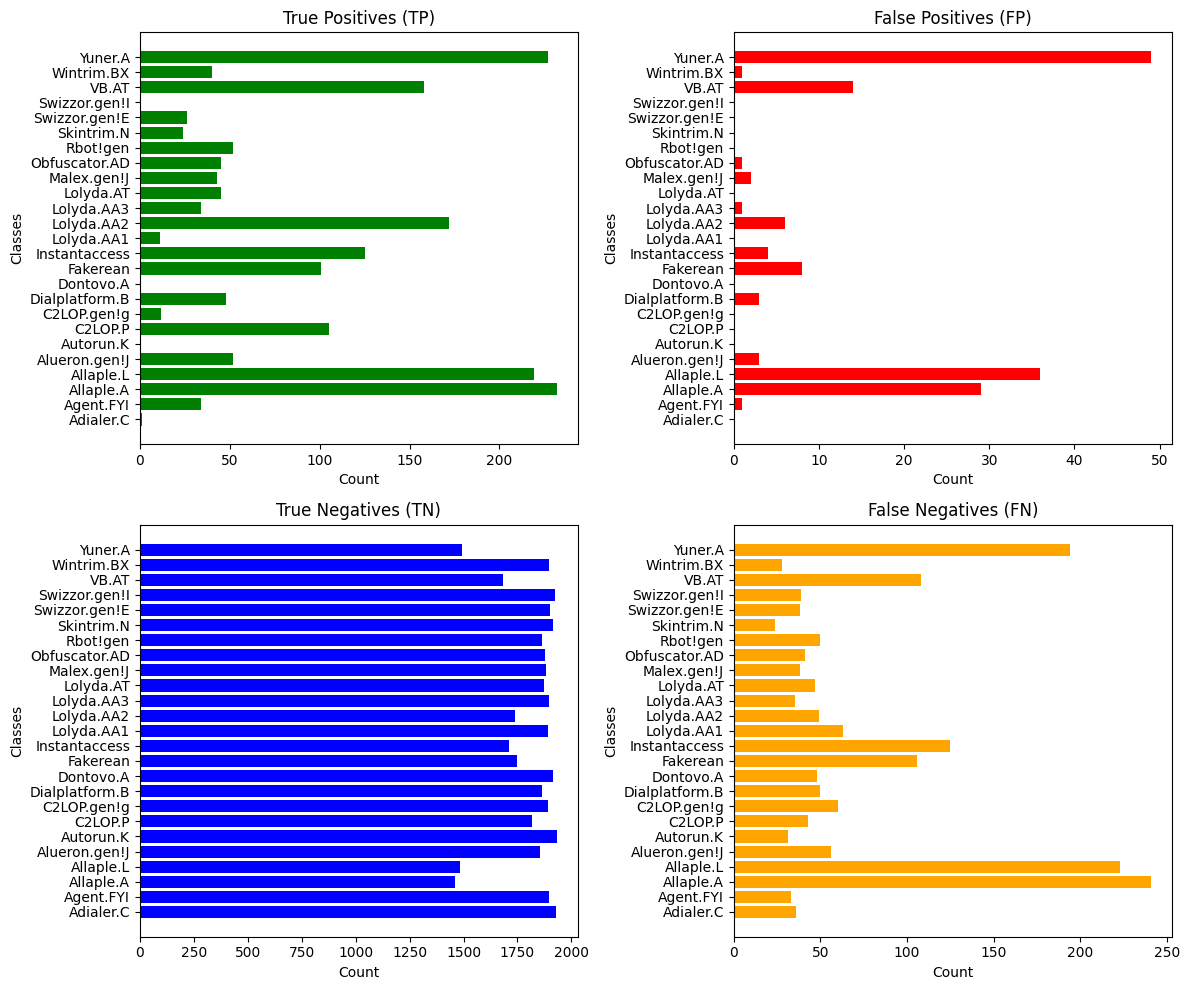

In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate predictions for the test set
y_pred = final_model.predict(test_batches, batch_size=256)

# Retrieve the true labels from the test set
y_true = test_batches.labels  # True labels

# Convert the predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Calculate TP, FP, TN, FN for each class
TP = np.diag(conf_matrix)  # Diagonal elements are True Positives
FP = np.sum(conf_matrix, axis=0) - TP  # Sum of columns - TP (False Positives)
FN = np.sum(conf_matrix, axis=1) - TP  # Sum of rows - TP (False Negatives)
TN = np.sum(conf_matrix) - (TP + FP + FN)  # Total - (TP + FP + FN)

# Get the class names from the training set indices
class_names = list(test_batches.class_indices.keys())  # List of class names

# Create a figure to display TP, FP, TN, FN
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Display True Positives 
axes[0, 0].barh(class_names, FP, color='green')
axes[0, 0].set_title('True Positives (TP)')
axes[0, 0].set_xlabel('Count')
axes[0, 0].set_ylabel('Classes')

# Display False Positives 
axes[0, 1].barh(class_names, TP, color='red')
axes[0, 1].set_title('False Positives (FP)')
axes[0, 1].set_xlabel('Count')
axes[0, 1].set_ylabel('Classes')

# Display True Negatives 
axes[1, 0].barh(class_names, TN, color='blue')
axes[1, 0].set_title('True Negatives (TN)')
axes[1, 0].set_xlabel('Count')
axes[1, 0].set_ylabel('Classes')

# Display False Negatives &
axes[1, 1].barh(class_names, FN, color='orange')
axes[1, 1].set_title('False Negatives (FN)')
axes[1, 1].set_xlabel('Count')
axes[1, 1].set_ylabel('Classes')

# Adjust spacing for better readability
plt.tight_layout()
plt.show()


## Conclusion

In this project, we successfully trained and evaluated a deep learning model for malware classification. We performed a comprehensive evaluation of the model's performance using various metrics such as accuracy, precision, recall, F1 score, confusion matrix, and ROC curve.


Thank you for reviewing this project.
